In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'all_tracking_data_antwerp_away.csv'
data = pd.read_csv(file_path)

# Filter data for frames between 583 and 673
start_frame = 583
end_frame = 673
pass_sequence = data[(data['Frame'] >= start_frame) & (data['Frame'] <= end_frame)]

# Debug: Print unique IDs to check if '362' and '393' are present
print("Unique player IDs in the selected frames:", pass_sequence['ID'].unique())

# Extract bbox coordinates for player 362 and player 393
def parse_bbox(bbox_str):
    return list(map(float, bbox_str.strip('[]').split(',')))

# Ensure the 'ID' column is treated as a float
pass_sequence['ID'] = pass_sequence['ID'].astype(float)

# Check if player IDs 362.0 and 393.0 exist
if 362.0 in pass_sequence['ID'].values and 393.0 in pass_sequence['ID'].values:
    player_362_bbox = pass_sequence[pass_sequence['ID'] == 362.0]['bbox'].values[0]
    player_393_bbox = pass_sequence[pass_sequence['ID'] == 393.0]['bbox'].values[0]

    player_362_x1, player_362_y1, player_362_x2, player_362_y2 = parse_bbox(player_362_bbox)
    player_393_x1, player_393_y1, player_393_x2, player_393_y2 = parse_bbox(player_393_bbox)

    # Get all players' bbox coordinates between frames 583 and 673
    players_between = pass_sequence[(pass_sequence['ID'] != 362.0) & (pass_sequence['ID'] != 393.0)]

    # Filter for the opposing team players
    opposing_team = players_between[players_between['team'] != 1.0]

    # Check which opposing players are vertically aligned between player 362 and player 393
    opposing_players_in_between = []

    for index, row in opposing_team.iterrows():
        bbox = parse_bbox(row['bbox'])
        x1, y1, x2, y2 = bbox
        if (player_362_y1 <= y1 <= player_393_y2) or (player_362_y1 <= y2 <= player_393_y2):
            opposing_players_in_between.append(row['ID'])

    # Get unique opposing players between
    unique_opposing_players_in_between = set(opposing_players_in_between)

    # Plot the football field
    fig, ax = plt.subplots(figsize=(10, 6))

    # Function to plot a bounding box
    def plot_bbox(ax, bbox, label, color):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
        ax.add_patch(rect)
        plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

    # Plot the bounding boxes for player 362 and player 393
    plot_bbox(ax, [player_362_x1, player_362_y1, player_362_x2, player_362_y2], '362 (Team 1)', 'blue')
    plot_bbox(ax, [player_393_x1, player_393_y1, player_393_x2, player_393_y2], '393 (Team 1)', 'blue')

    # Plot the bounding boxes for the opposing players
    for player_id in unique_opposing_players_in_between:
        player_bbox = parse_bbox(opposing_team[opposing_team['ID'] == player_id]['bbox'].values[0])
        plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')

    # Draw the pass between player 362 and player 393
    player_362_center = [(player_362_x1 + player_362_x2) / 2, (player_362_y1 + player_362_y2) / 2]
    player_393_center = [(player_393_x1 + player_393_x2) / 2, (player_393_y1 + player_393_y2) / 2]
    ax.arrow(player_362_center[0], player_362_center[1], player_393_center[0] - player_362_center[0], player_393_center[1] - player_362_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

    # Set plot limits
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)

    # Add labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Pass from Player 362 to Player 393 with Opposing Players')

    # Show the plot
    plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
    plt.show()
else:
    print("Player IDs 362 or 393 not found in the selected frames.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'all_tracking_data_antwerp_away.csv'
data = pd.read_csv(file_path)

# Step 1: Identify the frame where player 362 has the ball
frames_with_ball_362 = data[(data['ID'] == 362) & (data['Has Ball'] == True)]['Frame']

# Determine the frame just before the pass
initial_frame = frames_with_ball_362.iloc[-1]  # The last frame where player 362 has the ball

# Get the coordinates of player 362 in the initial frame
initial_frame_data = data[(data['Frame'] == initial_frame) & (data['ID'] == 362)]
player_362_bbox = eval(initial_frame_data['bbox'].values[0])
player_362_x1, player_362_y1, player_362_x2, player_362_y2 = player_362_bbox

# Check if player 393 is visible in the initial frame
is_player_393_visible = not data[(data['Frame'] == initial_frame) & (data['ID'] == 393)].empty

# If player 393 is not visible, find the next frame where player 393 is visible
if not is_player_393_visible:
    frames_with_393 = data[(data['ID'] == 393)]['Frame']
    next_visible_frame = frames_with_393[frames_with_393 > initial_frame].iloc[0]
else:
    next_visible_frame = initial_frame

# Get the coordinates of player 393 in the next visible frame
next_frame_data = data[(data['Frame'] == next_visible_frame) & (data['ID'] == 393)]
player_393_bbox = eval(next_frame_data['bbox'].values[0])
player_393_x1, player_393_y1, player_393_x2, player_393_y2 = player_393_bbox

# Filter data for the initial frame and opposing team players
initial_opposing_team_data = data[(data['Frame'] == initial_frame) & (data['team'] != 1.0)]

# Determine the direction of the pass (left or right)
direction = "right" if player_393_x1 > player_362_x2 else "left"

# Count the number of opposing players in front of player 362 in the direction of player 393
opposing_players_in_front = []

for index, row in initial_opposing_team_data.iterrows():
    bbox = eval(row['bbox'])
    x1, y1, x2, y2 = bbox
    if direction == "right" and x1 > player_362_x2:
        opposing_players_in_front.append(row['ID'])
    elif direction == "left" and x2 < player_362_x1:
        opposing_players_in_front.append(row['ID'])

# Get unique opposing players in front
unique_opposing_players_in_front = set(opposing_players_in_front)

# Plot the football field
fig, ax = plt.subplots(figsize=(10, 6))

# Function to plot a bounding box
def plot_bbox(ax, bbox, label, color):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

# Plot the bounding boxes for player 362 and player 393
plot_bbox(ax, player_362_bbox, '362 (Team 1)', 'blue')
plot_bbox(ax, player_393_bbox, '393 (Team 1)', 'blue')

# Plot the bounding boxes for the opposing players
for player_id in unique_opposing_players_in_front:
    player_bbox = eval(initial_opposing_team_data[initial_opposing_team_data['ID'] == player_id]['bbox'].values[0])
    plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')

# Draw the pass between player 362 and player 393
player_362_center = [(player_362_x1 + player_362_x2) / 2, (player_362_y1 + player_362_y2) / 2]
player_393_center = [(player_393_x1 + player_393_x2) / 2, (player_393_y1 + player_393_y2) / 2]
ax.arrow(player_362_center[0], player_362_center[1], player_393_center[0] - player_362_center[0], player_393_center[1] - player_362_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

# Set plot limits
ax.set_xlim(0, 1920)
ax.set_ylim(0, 1080)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Pass from Player 362 to Player 393 with Opposing Players')

# Show the plot
plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'all_tracking_data_antwerp_away.csv'
data = pd.read_csv(file_path)

# Function to detect successful passes
def detect_successful_passes(data):
    passes = []
    players_with_ball = data[data['Has Ball'] == True].reset_index(drop=True)
    
    for i in range(len(players_with_ball) - 1):
        current_entry = players_with_ball.iloc[i]
        next_entry = players_with_ball.iloc[i + 1]

        # Check if the pass is within the same team and no opposing player intercepts
        if current_entry['team'] == next_entry['team']:
            frame = current_entry['Frame']
            next_frame = next_entry['Frame']

            in_between_frames = data[(data['Frame'] > frame) & (data['Frame'] < next_frame)]
            opposing_with_ball = in_between_frames[(in_between_frames['Has Ball'] == True) & (in_between_frames['team'] != current_entry['team'])]

            if opposing_with_ball.empty:
                passes.append((current_entry, next_entry))

    return passes

# Detect successful passes
successful_passes = detect_successful_passes(data)

# Function to plot a bounding box
def plot_bbox(ax, bbox, label, color):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

# Process and plot each detected successful pass
for pass_info in successful_passes:
    player_A, player_B = pass_info
    
    # Get the initial frame and next visible frame
    initial_frame = player_A['Frame']
    next_visible_frame = player_B['Frame']
    
    # Get the coordinates of player A in the initial frame
    player_A_bbox = eval(player_A['bbox'])
    player_A_x1, player_A_y1, player_A_x2, player_A_y2 = player_A_bbox

    # Get the coordinates of player B in the next visible frame
    player_B_bbox = eval(player_B['bbox'])
    player_B_x1, player_B_y1, player_B_x2, player_B_y2 = player_B_bbox

    # Filter data for the initial frame and opposing team players
    initial_opposing_team_data = data[(data['Frame'] == initial_frame) & (data['team'] != player_A['team'])]

    # Determine the direction of the pass (left or right)
    direction = "right" if player_B_x1 > player_A_x2 else "left"

    # Count the number of opposing players in front of player A in the direction of player B
    opposing_players_in_front = []

    for index, row in initial_opposing_team_data.iterrows():
        bbox = eval(row['bbox'])
        x1, y1, x2, y2 = bbox
        if direction == "right" and x1 > player_A_x2:
            opposing_players_in_front.append(row['ID'])
        elif direction == "left" and x2 < player_A_x1:
            opposing_players_in_front.append(row['ID'])

    # Get unique opposing players in front
    unique_opposing_players_in_front = set(opposing_players_in_front)

    # Plot the football field
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bounding boxes for player A and player B
    plot_bbox(ax, player_A_bbox, f'{player_A["ID"]} (Team {player_A["team"]})', 'blue')
    plot_bbox(ax, player_B_bbox, f'{player_B["ID"]} (Team {player_B["team"]})', 'blue')

    # Plot the bounding boxes for the opposing players
    for player_id in unique_opposing_players_in_front:
        player_bbox = eval(initial_opposing_team_data[initial_opposing_team_data['ID'] == player_id]['bbox'].values[0])
        plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')

    # Draw the pass between player A and player B
    player_A_center = [(player_A_x1 + player_A_x2) / 2, (player_A_y1 + player_A_y2) / 2]
    player_B_center = [(player_B_x1 + player_B_x2) / 2, (player_B_y1 + player_B_y2) / 2]
    ax.arrow(player_A_center[0], player_A_center[1], player_B_center[0] - player_A_center[0], player_B_center[1] - player_A_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

    # Set plot limits
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)

    # Add labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title(f'Pass from Player {player_A["ID"]} to Player {player_B["ID"]} with Opposing Players')

    # Show the plot
    plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'all_tracking_data_antwerp_away.csv'
data = pd.read_csv(file_path)

# Function to detect successful passes
def detect_successful_passes(data):
    passes = []
    players_with_ball = data[data['Has Ball'] == True].reset_index(drop=True)
    
    for i in range(len(players_with_ball) - 1):
        current_entry = players_with_ball.iloc[i]
        next_entry = players_with_ball.iloc[i + 1]

        # Check if the pass is within the same team and no opposing player intercepts
        if current_entry['team'] == next_entry['team']:
            frame = current_entry['Frame']
            next_frame = next_entry['Frame']

            in_between_frames = data[(data['Frame'] > frame) & (data['Frame'] < next_frame)]
            opposing_with_ball = in_between_frames[(in_between_frames['Has Ball'] == True) & (in_between_frames['team'] != current_entry['team'])]

            if opposing_with_ball.empty:
                passes.append((current_entry, next_entry))

    return passes

# Detect successful passes
successful_passes = detect_successful_passes(data)

# Function to plot a bounding box
def plot_bbox(ax, bbox, label, color):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

# Process and plot each detected successful pass
for pass_info in successful_passes:
    player_A, player_B = pass_info
    
    # Get the initial frame and next visible frame
    initial_frame = player_A['Frame']
    next_visible_frame = player_B['Frame']
    
    # Get the coordinates of player A in the initial frame
    initial_frame_data = data[(data['Frame'] == initial_frame) & (data['ID'] == player_A['ID'])]
    player_A_bbox = eval(initial_frame_data['bbox'].values[0])
    player_A_x1, player_A_y1, player_A_x2, player_A_y2 = player_A_bbox

    # Check if player B is visible in the initial frame
    is_player_B_visible = not data[(data['Frame'] == initial_frame) & (data['ID'] == player_B['ID'])].empty

    # If player B is not visible, find the next frame where player B is visible
    if not is_player_B_visible:
        frames_with_B = data[(data['ID'] == player_B['ID'])]['Frame']
        next_visible_frame = frames_with_B[frames_with_B > initial_frame].iloc[0]
    else:
        next_visible_frame = initial_frame

    # Get the coordinates of player B in the next visible frame
    next_frame_data = data[(data['Frame'] == next_visible_frame) & (data['ID'] == player_B['ID'])]
    player_B_bbox = eval(next_frame_data['bbox'].values[0])
    player_B_x1, player_B_y1, player_B_x2, player_B_y2 = player_B_bbox

    # Filter data for the initial frame and opposing team players
    initial_opposing_team_data = data[(data['Frame'] == initial_frame) & (data['team'] != player_A['team'])]

    # Determine the direction of the pass (left or right)
    direction = "right" if player_B_x1 > player_A_x2 else "left"

    # Count the number of opposing players in front of player A in the direction of player B
    opposing_players_in_front = []

    for index, row in initial_opposing_team_data.iterrows():
        bbox = eval(row['bbox'])
        x1, y1, x2, y2 = bbox
        if direction == "right" and x1 > player_A_x2:
            opposing_players_in_front.append(row['ID'])
        elif direction == "left" and x2 < player_A_x1:
            opposing_players_in_front.append(row['ID'])

    # Get unique opposing players in front
    unique_opposing_players_in_front = set(opposing_players_in_front)

    # Plot the football field
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bounding boxes for player A and player B
    plot_bbox(ax, player_A_bbox, f'{player_A["ID"]} (Team {player_A["team"]})', 'blue')
    plot_bbox(ax, player_B_bbox, f'{player_B["ID"]} (Team {player_B["team"]})', 'blue')

    # Plot the bounding boxes for the opposing players
    for player_id in unique_opposing_players_in_front:
        player_bbox = eval(initial_opposing_team_data[initial_opposing_team_data['ID'] == player_id]['bbox'].values[0])
        plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')

    # Draw the pass between player A and player B
    player_A_center = [(player_A_x1 + player_A_x2) / 2, (player_A_y1 + player_A_y2) / 2]
    player_B_center = [(player_B_x1 + player_B_x2) / 2, (player_B_y1 + player_B_y2) / 2]
    ax.arrow(player_A_center[0], player_A_center[1], player_B_center[0] - player_A_center[0], player_B_center[1] - player_A_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

    # Set plot limits
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)

    # Add labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title(f'Pass from Player {player_A["ID"]} to Player {player_B["ID"]} with Opposing Players')

    # Show the plot
    plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to detect successful passes
def detect_successful_passes(data):
    passes = []
    players_with_ball = data[data['has_ball'] == True].reset_index(drop=True)
    
    for i in range(len(players_with_ball) - 1):
        current_entry = players_with_ball.iloc[i]
        next_entry = players_with_ball.iloc[i + 1]

        # Check if the pass is within the same team and no opposing player intercepts
        if current_entry['team'] == next_entry['team']:
            frame = current_entry['Frame']
            next_frame = next_entry['Frame']

            in_between_frames = data[(data['Frame'] > frame) & (data['Frame'] < next_frame)]
            opposing_with_ball = in_between_frames[(in_between_frames['has_ball'] == True) & (in_between_frames['team'] != current_entry['team'])]

            if opposing_with_ball.empty:
                passes.append((current_entry, next_entry))

    return passes

# Detect successful passes
successful_passes = detect_successful_passes(data)

# Function to plot a bounding box
def plot_bbox(ax, bbox, label, color):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

# Function to check if a point is between two other points
def is_between(a, b, c):
    return a < c < b or b < c < a

# Process and plot each detected successful pass
for pass_info in successful_passes:
    player_A, player_B = pass_info
    
    # Get the initial frame and next visible frame
    initial_frame = player_A['Frame']
    next_visible_frame = player_B['Frame']
    
    # Get the coordinates of player A in the initial frame
    initial_frame_data = data[(data['Frame'] == initial_frame) & (data['ID'] == player_A['ID'])]
    player_A_bbox = eval(initial_frame_data['bbox'].values[0])
    player_A_x1, player_A_y1, player_A_x2, player_A_y2 = player_A_bbox

    # Check if player B is visible in the initial frame
    is_player_B_visible = not data[(data['Frame'] == initial_frame) & (data['ID'] == player_B['ID'])].empty

    # If player B is not visible, find the next frame where player B is visible
    if not is_player_B_visible:
        frames_with_B = data[(data['ID'] == player_B['ID'])]['Frame']
        next_visible_frame = frames_with_B[frames_with_B > initial_frame].iloc[0]
    else:
        next_visible_frame = initial_frame

    # Get the coordinates of player B in the next visible frame
    next_frame_data = data[(data['Frame'] == next_visible_frame) & (data['ID'] == player_B['ID'])]
    player_B_bbox = eval(next_frame_data['bbox'].values[0])
    player_B_x1, player_B_y1, player_B_x2, player_B_y2 = player_B_bbox

    # Filter data for the initial frame and opposing team players
    initial_opposing_team_data = data[(data['Frame'] == initial_frame) & (data['team'] != player_A['team']) & (data['Type'] == 'Player')]

    # Count the number of opposing players bypassed by the pass
    bypassed_opposing_players = []

    for index, row in initial_opposing_team_data.iterrows():
        bbox = eval(row['bbox'])
        x1, y1, x2, y2 = bbox
        if is_between(player_A_x1, player_B_x1, x1) or is_between(player_A_x2, player_B_x2, x2):
            bypassed_opposing_players.append(row['ID'])

    # Get unique opposing players bypassed
    unique_bypassed_opposing_players = set(bypassed_opposing_players)

    if not unique_bypassed_opposing_players:
        continue
    print(successful_passes)
    # Plot the football field
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bounding boxes for player A and player B
    plot_bbox(ax, player_A_bbox, f'{player_A["ID"]} (Team {player_A["team"]})', 'blue')
    plot_bbox(ax, player_B_bbox, f'{player_B["ID"]} (Team {player_B["team"]})', 'blue')

    # Plot the bounding boxes for the bypassed opposing players
    for player_id in unique_bypassed_opposing_players:
        player_bbox = eval(initial_opposing_team_data[initial_opposing_team_data['ID'] == player_id]['bbox'].values[0])
        plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')

    # Draw the pass between player A and player B
    player_A_center = [(player_A_x1 + player_A_x2) / 2, (player_A_y1 + player_A_y2) / 2]
    player_B_center = [(player_B_x1 + player_B_x2) / 2, (player_B_y1 + player_B_y2) / 2]
    ax.arrow(player_A_center[0], player_A_center[1], player_B_center[0] - player_A_center[0], player_B_center[1] - player_A_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

    # Set plot limits
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)

    # Add labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title(f'Pass from Player {player_A["ID"]} to Player {player_B["ID"]} with Bypassed Opposing Players')

    # Show the plot
    plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to detect successful passes
def detect_successful_passes(data):
    passes = []
    players_with_ball = data[data['has_ball'] == True].reset_index(drop=True)
    
    for i in range(len(players_with_ball) - 1):
        current_entry = players_with_ball.iloc[i]
        next_entry = players_with_ball.iloc[i + 1]

        # Check if the pass is within the same team and no opposing player intercepts
        if current_entry['team'] == next_entry['team']:
            frame = current_entry['Frame']
            next_frame = next_entry['Frame']

            in_between_frames = data[(data['Frame'] > frame) & (data['Frame'] < next_frame)]
            opposing_with_ball = in_between_frames[(in_between_frames['has_ball'] == True) & (in_between_frames['team'] != current_entry['team'])]

            if opposing_with_ball.empty:
                passes.append((current_entry, next_entry))

    return passes

# Detect successful passes
successful_passes = detect_successful_passes(data)

# Function to plot a bounding box
def plot_bbox(ax, bbox, label, color):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

# Function to check if a point is between two other points
def is_between(a, b, c):
    return a < c < b or b < c < a

# Process and plot each detected successful pass
for pass_info in successful_passes:
    player_A, player_B = pass_info
    
    # Get the initial frame and next visible frame
    initial_frame = player_A['Frame']
    next_visible_frame = player_B['Frame']
    
    # Get the coordinates of player A in the initial frame
    initial_frame_data = data[(data['Frame'] == initial_frame) & (data['ID'] == player_A['ID'])]
    player_A_bbox = eval(initial_frame_data['bbox'].values[0])
    player_A_x1, player_A_y1, player_A_x2, player_A_y2 = player_A_bbox

    # Check if player B is visible in the initial frame
    is_player_B_visible = not data[(data['Frame'] == initial_frame) & (data['ID'] == player_B['ID'])].empty

    # If player B is not visible, find the next frame where player B is visible
    if not is_player_B_visible:
        frames_with_B = data[(data['ID'] == player_B['ID'])]['Frame']
        next_visible_frame = frames_with_B[frames_with_B > initial_frame].iloc[0]
    else:
        next_visible_frame = initial_frame

    # Get the coordinates of player B in the next visible frame
    next_frame_data = data[(data['Frame'] == next_visible_frame) & (data['ID'] == player_B['ID'])]
    player_B_bbox = eval(next_frame_data['bbox'].values[0])
    player_B_x1, player_B_y1, player_B_x2, player_B_y2 = player_B_bbox

    # Filter data for the initial frame and opposing team players
    initial_opposing_team_data = data[(data['Frame'] == initial_frame) & (data['team'] != player_A['team']) & (data['Type'] == 'Player')]

    # Count the number of opposing players bypassed by the pass
    bypassed_opposing_players = []

    for index, row in initial_opposing_team_data.iterrows():
        bbox = eval(row['bbox'])
        x1, y1, x2, y2 = bbox
        if is_between(player_A_x1, player_B_x1, x1) or is_between(player_A_x2, player_B_x2, x2):
            bypassed_opposing_players.append(row['ID'])

    # Get unique opposing players bypassed
    unique_bypassed_opposing_players = set(bypassed_opposing_players)

    if not unique_bypassed_opposing_players:
        continue

    # Calculate the score for the pass
    score = len(unique_bypassed_opposing_players) * 0.5

    # Plot the football field
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bounding boxes for player A and player B
    plot_bbox(ax, player_A_bbox, f'{player_A["ID"]} (Team {player_A["team"]})', 'blue')
    plot_bbox(ax, player_B_bbox, f'{player_B["ID"]} (Team {player_B["team"]})', 'blue')

    # Plot the bounding boxes for the bypassed opposing players and add the score below each
    for player_id in unique_bypassed_opposing_players:
        player_bbox = eval(initial_opposing_team_data[initial_opposing_team_data['ID'] == player_id]['bbox'].values[0])
        plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')
        # Plot the score below the bypassed player
        plt.text(player_bbox[0], player_bbox[3], '0.5', fontsize=15, color='green', verticalalignment='top', horizontalalignment='center')

    # Draw the pass between player A and player B
    player_A_center = [(player_A_x1 + player_A_x2) / 2, (player_A_y1 + player_A_y2) / 2]
    player_B_center = [(player_B_x1 + player_B_x2) / 2, (player_B_y1 + player_B_y2) / 2]
    ax.arrow(player_A_center[0], player_A_center[1], player_B_center[0] - player_A_center[0], player_B_center[1] - player_A_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

    # Set plot limits
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)

    # Add labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title(f'Pass from Player {player_A["ID"]} to Player {player_B["ID"]} with Bypassed Opposing Players\nScore: {score}')

    # Show the plot
    plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
    plt.show()


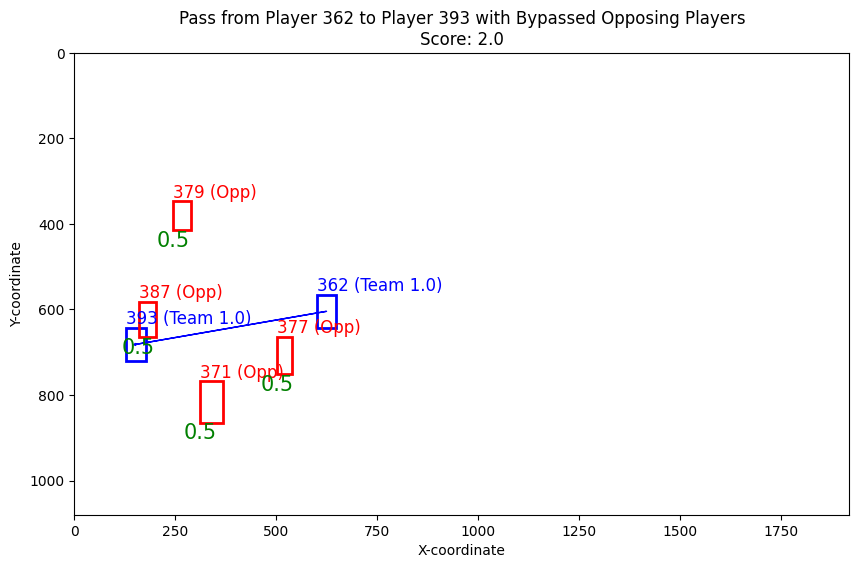

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to detect successful passes
def detect_successful_passes(data):
    passes = []
    players_with_ball = data[data['Has Ball'] == True].reset_index(drop=True)
    
    for i in range(len(players_with_ball) - 1):
        current_entry = players_with_ball.iloc[i]
        next_entry = players_with_ball.iloc[i + 1]

        # Check if the pass is within the same team and no opposing player intercepts
        if current_entry['Team'] == next_entry['Team']:
            frame = current_entry['Frame']
            next_frame = next_entry['Frame']

            in_between_frames = data[(data['Frame'] > frame) & (data['Frame'] < next_frame)]
            opposing_with_ball = in_between_frames[(in_between_frames['Has Ball'] == True) & (in_between_frames['Team'] != current_entry['Team'])]

            if opposing_with_ball.empty:
                passes.append((current_entry, next_entry))

    return passes

# Detect successful passes
successful_passes = detect_successful_passes(data)

# Function to plot a bounding box
def plot_bbox(ax, bbox, label, color):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

# Function to check if a point is between two other points
def is_between(a, b, c):
    return a < c < b or b < c < a

# Process and plot each detected successful pass
for pass_info in successful_passes:
    player_A, player_B = pass_info
    
    # Get the initial frame and next visible frame
    initial_frame = player_A['Frame']
    next_visible_frame = player_B['Frame']
    
    # Get the coordinates of player A in the initial frame
    initial_frame_data = data[(data['Frame'] == initial_frame) & (data['ID'] == player_A['ID'])]
    player_A_bbox = eval(initial_frame_data['BBox'].values[0])
    player_A_x1, player_A_y1, player_A_x2, player_A_y2 = player_A_bbox

    # Check if player B is visible in the initial frame
    is_player_B_visible = not data[(data['Frame'] == initial_frame) & (data['ID'] == player_B['ID'])].empty

    # If player B is not visible, find the next frame where player B is visible
    if not is_player_B_visible:
        frames_with_B = data[(data['ID'] == player_B['ID'])]['Frame']
        next_visible_frame = frames_with_B[frames_with_B > initial_frame].iloc[0]
    else:
        next_visible_frame = initial_frame

    # Get the coordinates of player B in the next visible frame
    next_frame_data = data[(data['Frame'] == next_visible_frame) & (data['ID'] == player_B['ID'])]
    player_B_bbox = eval(next_frame_data['BBox'].values[0])
    player_B_x1, player_B_y1, player_B_x2, player_B_y2 = player_B_bbox

    # Filter data for the initial frame and opposing team players
    initial_opposing_team_data = data[(data['Frame'] == initial_frame) & (data['Team'] != player_A['Team']) & (data['Type'] == 'Player')]

    # Count the number of opposing players bypassed by the pass
    bypassed_opposing_players = []

    for index, row in initial_opposing_team_data.iterrows():
        bbox = eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        if is_between(player_A_x1, player_B_x1, x1) or is_between(player_A_x2, player_B_x2, x2):
            bypassed_opposing_players.append(row['ID'])

    # Get unique opposing players bypassed
    unique_bypassed_opposing_players = set(bypassed_opposing_players)

    if not unique_bypassed_opposing_players:
        continue

    # Calculate the score for the pass
    score = len(unique_bypassed_opposing_players) * 0.5

    # Plot the football field
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bounding boxes for player A and player B
    plot_bbox(ax, player_A_bbox, f'{player_A["ID"]} (Team {player_A["Team"]})', 'blue')
    plot_bbox(ax, player_B_bbox, f'{player_B["ID"]} (Team {player_B["Team"]})', 'blue')

    # Plot the bounding boxes for the bypassed opposing players and add the score below each
    for player_id in unique_bypassed_opposing_players:
        player_bbox = eval(initial_opposing_team_data[initial_opposing_team_data['ID'] == player_id]['BBox'].values[0])
        plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')
        # Plot the score below the bypassed player
        plt.text(player_bbox[0], player_bbox[3], '0.5', fontsize=15, color='green', verticalalignment='top', horizontalalignment='center')

    # Draw the pass between player A and player B
    player_A_center = [(player_A_x1 + player_A_x2) / 2, (player_A_y1 + player_A_y2) / 2]
    player_B_center = [(player_B_x1 + player_B_x2) / 2, (player_B_y1 + player_B_y2) / 2]
    ax.arrow(player_A_center[0], player_A_center[1], player_B_center[0] - player_A_center[0], player_B_center[1] - player_A_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

    # Set plot limits
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)

    # Add labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title(f'Pass from Player {player_A["ID"]} to Player {player_B["ID"]} with Bypassed Opposing Players\nScore: {score}')

    # Show the plot
    plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
    plt.show()


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Clean the data by filtering out rows with missing or invalid bounding boxes
data = data.dropna(subset=['BBox'])
data = data[data['BBox'].apply(lambda x: isinstance(x, str) and len(eval(x)) == 4)]

# Function to normalize bounding box values
def normalize_bbox(bbox, max_width=1920, max_height=1080):
    x1, y1, x2, y2 = bbox
    scale_x = max_width / max(x2, x1)
    scale_y = max_height / max(y2, y1)
    scale = min(scale_x, scale_y)
    return [x * scale for x in [x1, y1, x2, y2]]

# Function to detect successful passes
def detect_successful_passes(data):
    passes = []
    players_with_ball = data[data['Has Ball'] == 'True'].reset_index(drop=True)
    
    for i in range(len(players_with_ball) - 1):
        current_entry = players_with_ball.iloc[i]
        next_entry = players_with_ball.iloc[i + 1]

        # Check if the pass is within the same team and no opposing player intercepts
        if current_entry['Team'] == next_entry['Team']:
            frame = current_entry['Frame']
            next_frame = next_entry['Frame']

            in_between_frames = data[(data['Frame'] > frame) & (data['Frame'] < next_frame)]
            opposing_with_ball = in_between_frames[(in_between_frames['Has Ball'] == 'True') & (in_between_frames['Team'] != current_entry['Team'])]

            if opposing_with_ball.empty:
                passes.append((current_entry, next_entry))

    return passes

# Function to plot a bounding box
def plot_bbox(ax, bbox, label, color):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.text(x1, y1, label, fontsize=12, color=color, verticalalignment='bottom')

# Function to check if a point is between two other points
def is_between(a, b, c):
    return a < c < b or b < c < a

# Calculate average bounding box of pitch circles
def average_pitch_parts(data, frames):
    pitch_parts_data = data[(data['Type'] == 'Pitch Part') & (data['ID'].str.contains('Central Circle')) & (data['Frame'].isin(frames))]
    if not pitch_parts_data.empty:
        bboxes = pitch_parts_data['BBox'].apply(eval).tolist()
        avg_bbox = np.mean(np.array(bboxes), axis=0)
        return avg_bbox
    return None

# Normalize all bounding boxes to fit within a reasonable plot size
def normalize_all_bboxes(data, max_width=1920, max_height=1080):
    normalized_bboxes = []
    for bbox in data['BBox']:
        if isinstance(bbox, str):
            bbox = eval(bbox)
        normalized_bboxes.append(normalize_bbox(bbox, max_width, max_height))
    data['Normalized BBox'] = normalized_bboxes
    return data

# Normalize bounding boxes in the dataset
data = normalize_all_bboxes(data)

# Calculate the relevant frames for pitch parts averaging
frames = data[data['Has Ball'] == 'True']['Frame'].unique()
avg_pitch_part_bbox = average_pitch_parts(data, frames)

# Process and plot each detected successful pass
successful_passes = detect_successful_passes(data)
if avg_pitch_part_bbox is not None:
    avg_pitch_part_bbox = normalize_bbox(avg_pitch_part_bbox)
    for pass_info in successful_passes:
        player_A, player_B = pass_info
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot average pitch circle
        x1, y1, x2, y2 = avg_pitch_part_bbox
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='green', facecolor='none', linestyle='dashed')
        ax.add_patch(rect)
        plt.text((x1 + x2) / 2, y1, 'Average Central Circle', fontsize=10, color='green', ha='center')

        # Get the initial frame and next visible frame
        initial_frame = player_A['Frame']
        next_visible_frame = player_B['Frame']
        
        # Get the coordinates of player A in the initial frame
        initial_frame_data = data[(data['Frame'] == initial_frame) & (data['ID'] == player_A['ID'])]
        player_A_bbox = initial_frame_data['Normalized BBox'].values[0]
        player_A_x1, player_A_y1, player_A_x2, player_A_y2 = player_A_bbox

        # Check if player B is visible in the initial frame
        is_player_B_visible = not data[(data['Frame'] == initial_frame) & (data['ID'] == player_B['ID'])].empty

        # If player B is not visible, find the next frame where player B is visible
        if not is_player_B_visible:
            frames_with_B = data[(data['ID'] == player_B['ID'])]['Frame']
            next_visible_frame = frames_with_B[frames_with_B > initial_frame].iloc[0]
        else:
            next_visible_frame = initial_frame

        # Get the coordinates of player B in the next visible frame
        next_frame_data = data[(data['Frame'] == next_visible_frame) & (data['ID'] == player_B['ID'])]
        player_B_bbox = next_frame_data['Normalized BBox'].values[0]
        player_B_x1, player_B_y1, player_B_x2, player_B_y2 = player_B_bbox

        # Filter data for the initial frame and opposing team players
        initial_opposing_team_data = data[(data['Frame'] == initial_frame) & (data['Team'] != player_A['Team']) & (data['Type'] == 'Player')]

        # Count the number of opposing players bypassed by the pass
        bypassed_opposing_players = []

        for index, row in initial_opposing_team_data.iterrows():
            bbox = row['Normalized BBox']
            x1, y1, x2, y2 = bbox
            if is_between(player_A_x1, player_B_x1, x1) or is_between(player_A_x2, player_B_x2, x2):
                bypassed_opposing_players.append(row['ID'])

        # Get unique opposing players bypassed
        unique_bypassed_opposing_players = set(bypassed_opposing_players)

        if not unique_bypassed_opposing_players:
            continue

        # Calculate the score for the pass
        score = len(unique_bypassed_opposing_players) * 0.5

        # Plot the bounding boxes for player A and player B
        plot_bbox(ax, player_A_bbox, f'{player_A["ID"]} (Team {player_A["Team"]})', 'blue')
        plot_bbox(ax, player_B_bbox, f'{player_B["ID"]} (Team {player_B["Team"]})', 'blue')

        # Plot the bounding boxes for the bypassed opposing players and add the score below each
        for player_id in unique_bypassed_opposing_players:
            player_bbox = initial_opposing_team_data[initial_opposing_team_data['ID'] == player_id]['Normalized BBox'].values[0]
            plot_bbox(ax, player_bbox, f'{player_id} (Opp)', 'red')
            # Plot the score below the bypassed player
            plt.text(player_bbox[0], player_bbox[3], '0.5', fontsize=15, color='green', verticalalignment='top', horizontalalignment='center')

        # Draw the pass between player A and player B
        player_A_center = [(player_A_x1 + player_A_x2) / 2, (player_A_y1 + player_A_y2) / 2]
        player_B_center = [(player_B_x1 + player_B_x2) / 2, (player_B_y1 + player_B_y2) / 2]
        ax.arrow(player_A_center[0], player_A_center[1], player_B_center[0] - player_A_center[0], player_B_center[1] - player_A_center[1], head_width=5, head_length=5, fc='blue', ec='blue')

        # Set plot limits
        ax.set_xlim(0, 1920)
        ax.set_ylim(0, 1080)

        # Add labels and title
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        plt.title(f'Pass from Player {player_A["ID"]} to Player {player_B["ID"]} with Bypassed Opposing Players\nScore: {score}')

        # Show the plot
        plt.gca().invert_yaxis()  # Invert y-axis to match typical football field coordinates
        plt.show()



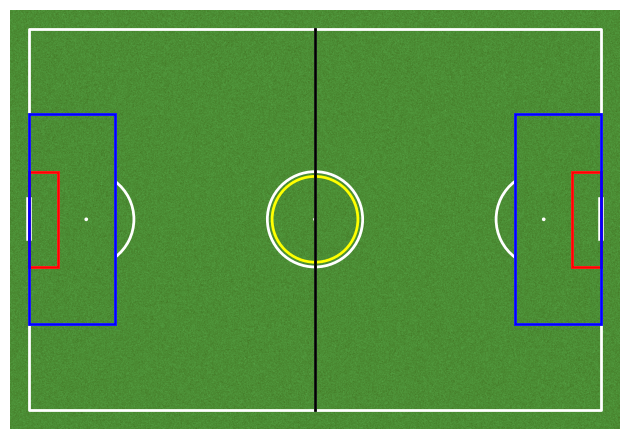

In [3]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Create a pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

# Draw the pitch
fig, ax = pitch.draw()

# Define different parts of the pitch
goal_area_left = plt.Rectangle((0, 30), 6, 20, edgecolor='red', facecolor='none', lw=2)
goal_area_right = plt.Rectangle((114, 30), 6, 20, edgecolor='red', facecolor='none', lw=2)
penalty_area_left = plt.Rectangle((0, 18), 18, 44, edgecolor='blue', facecolor='none', lw=2)
penalty_area_right = plt.Rectangle((102, 18), 18, 44, edgecolor='blue', facecolor='none', lw=2)
center_circle = plt.Circle((60, 40), 9, edgecolor='yellow', facecolor='none', lw=2)
halfway_line = plt.Line2D([60, 60], [0, 80], color='black', lw=2)

# Add parts to the pitch
ax.add_patch(goal_area_left)
ax.add_patch(goal_area_right)
ax.add_patch(penalty_area_left)
ax.add_patch(penalty_area_right)
ax.add_patch(center_circle)
ax.add_line(halfway_line)

# Show the pitch
plt.show()


                              ID  \
9315                      18Yard   
9316               18Yard Circle   
9317                       5Yard   
9318   First Half Central Circle   
9319            First Half Field   
9320  Second Half Central Circle   
9321           Second Half Field   

                                                   BBox  
9315  [1410.869140625, 59.08317947387695, 1919.57934...  
9316  [1506.403076171875, 179.8271026611328, 1761.58...  
9317  [1845.6572265625, 135.8695831298828, 1918.7502...  
9318  [85.72233581542969, 231.7085723876953, 444.760...  
9319  [6.69781494140625, 54.9268798828125, 487.90979...  
9320  [427.22296142578125, 228.3164520263672, 757.11...  
9321  [415.55181884765625, 3.15362548828125, 1912.02...  


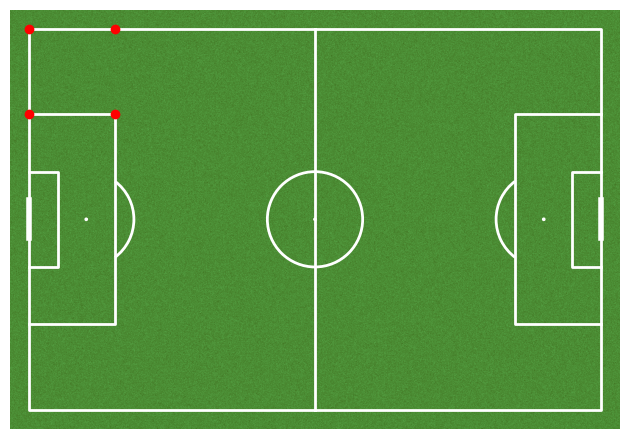

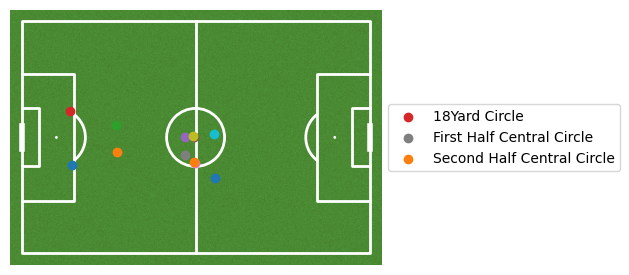

In [4]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Read the CSV file
tracking_data = pd.read_csv('all_tracking_data.csv')

# Select the rows from frame 583 for analysis
frame_583_data = tracking_data[tracking_data['Frame'] == 583]

# Extract bounding box coordinates for the relevant pitch parts
pitch_parts_bboxes = frame_583_data[frame_583_data['Type'] == 'Pitch Part'][['ID', 'BBox']]

# Convert bounding box strings to lists of floats
pitch_parts_bboxes['BBox'] = pitch_parts_bboxes['BBox'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

# Filter for specific pitch parts
specific_pitch_parts = pitch_parts_bboxes[pitch_parts_bboxes['ID'].isin(['First Half Central Circle', 'Second Half Central Circle', '18Yard Circle'])]

# Extract bounding boxes
bbox_first_half_circle = specific_pitch_parts[specific_pitch_parts['ID'] == 'First Half Central Circle']['BBox'].values[0]
bbox_second_half_circle = specific_pitch_parts[specific_pitch_parts['ID'] == 'Second Half Central Circle']['BBox'].values[0]
bbox_18yard_circle = specific_pitch_parts[specific_pitch_parts['ID'] == '18Yard Circle']['BBox'].values[0]

# Define corresponding points in the broadcast view (bounding box coordinates)
pts_src = np.array([
    [bbox_first_half_circle[0], bbox_first_half_circle[1]],  # Top-left
    [bbox_first_half_circle[2], bbox_first_half_circle[1]],  # Top-right
    [bbox_second_half_circle[0], bbox_second_half_circle[1]],  # Top-left
    [bbox_second_half_circle[2], bbox_second_half_circle[1]],  # Top-right
    [bbox_18yard_circle[0], bbox_18yard_circle[1]],  # Top-left
    [bbox_18yard_circle[2], bbox_18yard_circle[1]],  # Top-right
    [bbox_first_half_circle[0], bbox_first_half_circle[3]],  # Bottom-left
    [bbox_first_half_circle[2], bbox_first_half_circle[3]],  # Bottom-right
    [bbox_second_half_circle[0], bbox_second_half_circle[3]],  # Bottom-left
    [bbox_second_half_circle[2], bbox_second_half_circle[3]],  # Bottom-right
    [bbox_18yard_circle[0], bbox_18yard_circle[3]],  # Bottom-left
    [bbox_18yard_circle[2], bbox_18yard_circle[3]],  # Bottom-right
])

# Define corresponding points in the top-down pitch view (manual coordinates)
# Adjust these points based on known pitch dimensions and positions
pitch_width = 120  # Assuming pitch length is 120 units
pitch_height = 80  # Assuming pitch width is 80 units
pts_dst = np.array([
    [pitch_width / 2 - 9.15, pitch_height / 2],     # Top-left of First Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2],     # Top-right of First Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2],     # Top-left of Second Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2],     # Top-right of Second Half Central Circle
    [16.5, 40 + 9.15],  # Top-left of 18Yard Circle
    [16.5 + 18.3, 40 + 9.15],  # Top-right of 18Yard Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 + 9.15],     # Bottom-left of First Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 + 9.15],     # Bottom-right of First Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 + 9.15],     # Bottom-left of Second Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 + 9.15],     # Bottom-right of Second Half Central Circle
    [16.5, 40 - 9.15],  # Bottom-left of 18Yard Circle
    [16.5 + 18.3, 40 - 9.15],  # Bottom-right of 18Yard Circle
])

# Calculate the homography matrix
h_matrix, status = cv2.findHomography(pts_src, pts_dst)

# Function to apply homography transformation
def apply_homography(bbox, h_matrix):
    pts = np.array([
        [bbox[0], bbox[1]], 
        [bbox[2], bbox[1]], 
        [bbox[2], bbox[3]], 
        [bbox[0], bbox[3]]
    ], dtype='float32')
    pts = np.array([pts])
    transformed_pts = cv2.perspectiveTransform(pts, h_matrix)
    return transformed_pts

# Apply homography to the bounding boxes of all pitch parts
transformed_bboxes = {}
for index, row in specific_pitch_parts.iterrows():
    transformed_bboxes[row['ID']] = apply_homography(row['BBox'], h_matrix)

# Create a pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

# Draw the pitch
fig, ax = pitch.draw()

# Plot the transformed bounding boxes for all pitch parts
for part, transformed_bbox in transformed_bboxes.items():
    for point in transformed_bbox[0]:
        ax.scatter(point[0], point[1], label=part)

# Avoid overlapping labels by ensuring one label per part
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


First Half Central Circle: [85.72233581542969, 231.7085723876953, 444.7608947753906, 444.4124755859375]
Second Half Central Circle: [427.22296142578125, 228.3164520263672, 757.1167602539062, 441.0984191894531]
18Yard Circle: [1506.403076171875, 179.8271026611328, 1761.5870361328125, 324.705810546875]


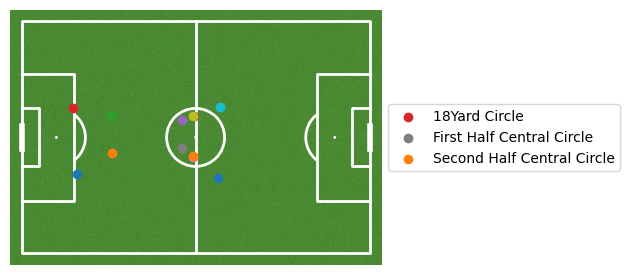

In [6]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Read the CSV file
tracking_data = pd.read_csv('all_tracking_data.csv')

# Select the rows from frame 583 for analysis
frame_583_data = tracking_data[tracking_data['Frame'] == 583]

# Extract bounding box coordinates for the relevant pitch parts
pitch_parts_bboxes = frame_583_data[frame_583_data['Type'] == 'Pitch Part'][['ID', 'BBox']]

# Convert bounding box strings to lists of floats
pitch_parts_bboxes['BBox'] = pitch_parts_bboxes['BBox'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

# Filter for specific pitch parts
specific_pitch_parts = pitch_parts_bboxes[pitch_parts_bboxes['ID'].isin(['First Half Central Circle', 'Second Half Central Circle', '18Yard Circle'])]

# Extract bounding boxes
bbox_first_half_circle = specific_pitch_parts[specific_pitch_parts['ID'] == 'First Half Central Circle']['BBox'].values[0]
bbox_second_half_circle = specific_pitch_parts[specific_pitch_parts['ID'] == 'Second Half Central Circle']['BBox'].values[0]
bbox_18yard_circle = specific_pitch_parts[specific_pitch_parts['ID'] == '18Yard Circle']['BBox'].values[0]

# Display extracted bounding boxes
print("First Half Central Circle:", bbox_first_half_circle)
print("Second Half Central Circle:", bbox_second_half_circle)
print("18Yard Circle:", bbox_18yard_circle)

# Define corresponding points in the broadcast view (bounding box coordinates)
pts_src = np.array([
    [bbox_first_half_circle[0], bbox_first_half_circle[1]],  # Top-left
    [bbox_first_half_circle[2], bbox_first_half_circle[1]],  # Top-right
    [bbox_first_half_circle[0], bbox_first_half_circle[3]],  # Bottom-left
    [bbox_first_half_circle[2], bbox_first_half_circle[3]],  # Bottom-right
    [bbox_second_half_circle[0], bbox_second_half_circle[1]],  # Top-left
    [bbox_second_half_circle[2], bbox_second_half_circle[1]],  # Top-right
    [bbox_second_half_circle[0], bbox_second_half_circle[3]],  # Bottom-left
    [bbox_second_half_circle[2], bbox_second_half_circle[3]],  # Bottom-right
    [bbox_18yard_circle[0], bbox_18yard_circle[1]],  # Top-left
    [bbox_18yard_circle[2], bbox_18yard_circle[1]],  # Top-right
    [bbox_18yard_circle[0], bbox_18yard_circle[3]],  # Bottom-left
    [bbox_18yard_circle[2], bbox_18yard_circle[3]]  # Bottom-right
])

# Define corresponding points in the top-down pitch view (manual coordinates)
pitch_width = 120  # Assuming pitch length is 120 units
pitch_height = 80  # Assuming pitch width is 80 units
pts_dst = np.array([
    [pitch_width / 2 - 9.15, pitch_height / 2 - 9.15],     # Top-left of First Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 - 9.15],     # Top-right of First Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 + 9.15],     # Bottom-left of First Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 + 9.15],     # Bottom-right of First Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 - 9.15],     # Top-left of Second Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 - 9.15],     # Top-right of Second Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 + 9.15],     # Bottom-left of Second Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 + 9.15],     # Bottom-right of Second Half Central Circle
    [16.5, 40 + 9.15],  # Top-left of 18Yard Circle
    [16.5 + 18.3, 40 + 9.15],  # Top-right of 18Yard Circle
    [16.5, 40 - 9.15],  # Bottom-left of 18Yard Circle
    [16.5 + 18.3, 40 - 9.15]  # Bottom-right of 18Yard Circle
])

# Calculate the homography matrix
h_matrix, status = cv2.findHomography(pts_src, pts_dst)

# Function to apply homography transformation
def apply_homography(bbox, h_matrix):
    pts = np.array([
        [bbox[0], bbox[1]], 
        [bbox[2], bbox[1]], 
        [bbox[2], bbox[3]], 
        [bbox[0], bbox[3]]
    ], dtype='float32')
    pts = np.array([pts])
    transformed_pts = cv2.perspectiveTransform(pts, h_matrix)
    return transformed_pts

# Apply homography to the bounding boxes of all pitch parts
transformed_bboxes = {}
for index, row in specific_pitch_parts.iterrows():
    transformed_bboxes[row['ID']] = apply_homography(row['BBox'], h_matrix)

# Create a pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

# Draw the pitch
fig, ax = pitch.draw()

# Plot the transformed bounding boxes for all pitch parts
for part, transformed_bbox in transformed_bboxes.items():
    for point in transformed_bbox[0]:
        ax.scatter(point[0], point[1], label=part)

# Avoid overlapping labels by ensuring one label per part
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


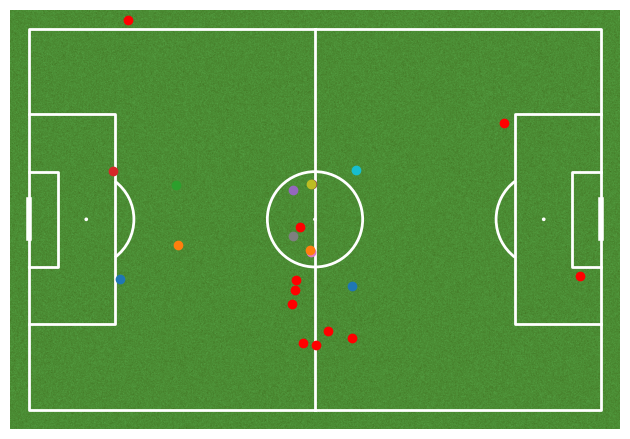

In [7]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Read the CSV file
tracking_data = pd.read_csv('all_tracking_data.csv')

# Select the rows from frame 583 for analysis
frame_583_data = tracking_data[tracking_data['Frame'] == 583]

# Extract bounding box coordinates for the relevant pitch parts
pitch_parts_bboxes = frame_583_data[frame_583_data['Type'] == 'Pitch Part'][['ID', 'BBox']]
# Extract player coordinates
player_coordinates = frame_583_data[frame_583_data['Type'] == 'Player'][['ID', 'BBox']]

# Convert bounding box strings to lists of floats
pitch_parts_bboxes['BBox'] = pitch_parts_bboxes['BBox'].apply(lambda x: list(map(float, x.strip('[]').split(','))))
player_coordinates['BBox'] = player_coordinates['BBox'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

# Filter for specific pitch parts
specific_pitch_parts = pitch_parts_bboxes[pitch_parts_bboxes['ID'].isin(['First Half Central Circle', 'Second Half Central Circle', '18Yard Circle'])]

# Extract bounding boxes
bbox_first_half_circle = specific_pitch_parts[specific_pitch_parts['ID'] == 'First Half Central Circle']['BBox'].values[0]
bbox_second_half_circle = specific_pitch_parts[specific_pitch_parts['ID'] == 'Second Half Central Circle']['BBox'].values[0]
bbox_18yard_circle = specific_pitch_parts[specific_pitch_parts['ID'] == '18Yard Circle']['BBox'].values[0]

# Define corresponding points in the broadcast view (bounding box coordinates)
pts_src = np.array([
    [bbox_first_half_circle[0], bbox_first_half_circle[1]],  # Top-left
    [bbox_first_half_circle[2], bbox_first_half_circle[1]],  # Top-right
    [bbox_first_half_circle[0], bbox_first_half_circle[3]],  # Bottom-left
    [bbox_first_half_circle[2], bbox_first_half_circle[3]],  # Bottom-right
    [bbox_second_half_circle[0], bbox_second_half_circle[1]],  # Top-left
    [bbox_second_half_circle[2], bbox_second_half_circle[1]],  # Top-right
    [bbox_second_half_circle[0], bbox_second_half_circle[3]],  # Bottom-left
    [bbox_second_half_circle[2], bbox_second_half_circle[3]],  # Bottom-right
    [bbox_18yard_circle[0], bbox_18yard_circle[1]],  # Top-left
    [bbox_18yard_circle[2], bbox_18yard_circle[1]],  # Top-right
    [bbox_18yard_circle[0], bbox_18yard_circle[3]],  # Bottom-left
    [bbox_18yard_circle[2], bbox_18yard_circle[3]]  # Bottom-right
])

# Define corresponding points in the top-down pitch view (manual coordinates)
pitch_width = 120  # Assuming pitch length is 120 units
pitch_height = 80  # Assuming pitch width is 80 units
pts_dst = np.array([
    [pitch_width / 2 - 9.15, pitch_height / 2 - 9.15],     # Top-left of First Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 - 9.15],     # Top-right of First Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 + 9.15],     # Bottom-left of First Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 + 9.15],     # Bottom-right of First Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 - 9.15],     # Top-left of Second Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 - 9.15],     # Top-right of Second Half Central Circle
    [pitch_width / 2 - 9.15, pitch_height / 2 + 9.15],     # Bottom-left of Second Half Central Circle
    [pitch_width / 2 + 9.15, pitch_height / 2 + 9.15],     # Bottom-right of Second Half Central Circle
    [16.5, 40 + 9.15],  # Top-left of 18Yard Circle
    [16.5 + 18.3, 40 + 9.15],  # Top-right of 18Yard Circle
    [16.5, 40 - 9.15],  # Bottom-left of 18Yard Circle
    [16.5 + 18.3, 40 - 9.15]  # Bottom-right of 18Yard Circle
])

# Calculate the homography matrix
h_matrix, status = cv2.findHomography(pts_src, pts_dst)

# Function to apply homography transformation
def apply_homography(bbox, h_matrix):
    pts = np.array([
        [bbox[0], bbox[1]], 
        [bbox[2], bbox[1]], 
        [bbox[2], bbox[3]], 
        [bbox[0], bbox[3]]
    ], dtype='float32')
    pts = np.array([pts])
    transformed_pts = cv2.perspectiveTransform(pts, h_matrix)
    return transformed_pts

# Function to apply homography to player coordinates
def apply_homography_to_point(point, h_matrix):
    pts = np.array([[point]], dtype='float32')
    transformed_pt = cv2.perspectiveTransform(pts, h_matrix)
    return transformed_pt[0][0]

# Apply homography to the bounding boxes of all pitch parts
transformed_bboxes = {}
for index, row in specific_pitch_parts.iterrows():
    transformed_bboxes[row['ID']] = apply_homography(row['BBox'], h_matrix)

# Apply homography to player coordinates
transformed_players = {}
for index, row in player_coordinates.iterrows():
    bbox = row['BBox']
    # Take the center of the bounding box as the player position
    center_x = (bbox[0] + bbox[2]) / 2
    center_y = (bbox[1] + bbox[3]) / 2
    transformed_players[row['ID']] = apply_homography_to_point([center_x, center_y], h_matrix)

# Create a pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

# Draw the pitch
fig, ax = pitch.draw()

# Plot the transformed bounding boxes for all pitch parts
for part, transformed_bbox in transformed_bboxes.items():
    for point in transformed_bbox[0]:
        ax.scatter(point[0], point[1], label=part)

# Plot the transformed player positions
for player_id, transformed_pt in transformed_players.items():
    ax.scatter(transformed_pt[0], transformed_pt[1], color='red')  # You can use different colors for different teams

plt.show()


In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to draw pitch parts and players on a frame
def draw_overlay(frame, pitch_part_data, player_data):
    for _, row in pitch_part_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)  # Red for pitch parts
        cv2.putText(frame, row['ID'], (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    for _, row in player_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Blue for players
        cv2.putText(frame, f'Player {row["ID"]}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to extract frames and add overlays
def extract_and_overlay_frames(video_path, output_folder, frame_numbers, team_color):
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_extracted = 0
    
    for frame_number in frame_numbers:
        if frame_number >= frame_count:
            print(f"Frame {frame_number} exceeds the video frame count {frame_count}. Skipping.")
            continue
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Failed to read frame {frame_number}.")
            continue
        
        frame_data = data[data['Frame'] == frame_number]
        pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
        team_players_data = frame_data[(frame_data['Team'] == 2) & (frame_data['Type'] == 'Player')]

        frame = draw_overlay(frame, pitch_part_data, team_players_data)
        
        output_path = f"{output_folder}/frame_{frame_number}.png"
        cv2.imwrite(output_path, frame)
        frames_extracted += 1
    
    cap.release()
    print(f"Extracted and processed {frames_extracted} frames.")

# Extract and overlay frames
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path
output_folder = 'output_frames'  # Replace with your desired output folder path
frame_numbers = [556, 557, 558]  # Replace with your frame numbers

extract_and_overlay_frames(video_path, output_folder, frame_numbers, 'blue')


In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to draw pitch parts and players on a frame
def draw_overlay(frame, pitch_part_data, player_data):
    for _, row in pitch_part_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)  # Red for pitch parts
        cv2.putText(frame, row['ID'], (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    for _, row in player_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Blue for players
        cv2.putText(frame, f'Player {row["ID"]}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to extract frames, add overlays, and save them to the original video
def extract_and_overlay_to_video(video_path, output_video_path, frame_numbers, team_color):
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' or 'mp4v'
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx in frame_numbers:
            frame_data = data[data['Frame'] == frame_idx]
            pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
            team_players_data = frame_data[(frame_data['Team'] == 2) & (frame_data['Type'] == 'Player')]

            frame = draw_overlay(frame, pitch_part_data, team_players_data)
        
        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Processed video saved to {output_video_path}")

# Identify frames where player 362 has the ball until player 393 gets the ball
frames_with_player_362_has_ball = data[(data['ID'] == '362') & (data['Has Ball'] == True)]['Frame'].unique()
frames_with_player_393_has_ball = data[(data['ID'] == '393') & (data['Has Ball'] == True)]['Frame'].unique()

# Identify the range of frames
if frames_with_player_362_has_ball.size > 0 and frames_with_player_393_has_ball.size > 0:
    start_frame = frames_with_player_362_has_ball[0]
    end_frame = frames_with_player_393_has_ball[0]
    relevant_frames = list(range(start_frame, end_frame + 1))
else:
    relevant_frames = []

# Extract and overlay the relevant frames and save to the original video
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path
output_video_path = 'output_video.mp4'  # Replace with your desired output video file path

extract_and_overlay_to_video(video_path, output_video_path, relevant_frames, 'blue')


In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to draw pitch parts and players on a frame
def draw_overlay(frame, pitch_part_data, player_data):
    for _, row in pitch_part_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)  # Red for pitch parts
        cv2.putText(frame, row['ID'], (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    for _, row in player_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Blue for players
        cv2.putText(frame, f'Player {row["ID"]}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to extract frames, add overlays, save them, and create video
def extract_and_overlay_to_video(video_path, output_folder, output_video_path, frame_numbers, team_color):
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' or 'mp4v'
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    frame_idx = 0
    frames_extracted = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx in frame_numbers:
            frame_data = data[data['Frame'] == frame_idx]
            pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
            team_players_data = frame_data[(frame_data['Team'] == 2) & (frame_data['Type'] == 'Player')]

            frame = draw_overlay(frame, pitch_part_data, team_players_data)
            
            # Save the frame as PNG
            output_path = f"{output_folder}/frame_{frame_idx}.png"
            cv2.imwrite(output_path, frame)
            frames_extracted += 1
        
        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Extracted and processed {frames_extracted} frames.")
    print(f"Processed video saved to {output_video_path}")

# Identify frames where player 362 has the ball until player 393 gets the ball
frames_with_player_362_has_ball = data[(data['ID'] == '362') & (data['Has Ball'] == True)]['Frame'].unique()
frames_with_player_393_has_ball = data[(data['ID'] == '393') & (data['Has Ball'] == True)]['Frame'].unique()

# Identify the range of frames with additional 10 frames before and after
if frames_with_player_362_has_ball.size > 0 and frames_with_player_393_has_ball.size > 0:
    start_frame = max(frames_with_player_362_has_ball[0] - 10, 0)
    end_frame = min(frames_with_player_393_has_ball[-1] + 10, data['Frame'].max())
    relevant_frames = list(range(start_frame, end_frame + 1))
else:
    relevant_frames = []

# Extract and overlay the relevant frames and save to the original video
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path
output_folder = 'output_frames'  # Replace with your desired output folder path
output_video_path = 'output_video.mp4'  # Replace with your desired output video file path

extract_and_overlay_to_video(video_path, output_folder, output_video_path, relevant_frames, 'blue')


In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to draw pitch parts and players on a frame
def draw_overlay(frame, pitch_part_data, player_data):
    for _, row in pitch_part_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)  # Red for pitch parts
        cv2.putText(frame, row['ID'], (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    for _, row in player_data.iterrows():
        bbox = ast.literal_eval(row['BBox'])
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Blue for players
        cv2.putText(frame, f'Player {row["ID"]}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to extract frames, add overlays, save them, and create a trimmed video
def extract_and_overlay_to_video(video_path, output_folder, output_video_path, frame_numbers):
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' or 'mp4v'
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    frames_extracted = 0
    for frame_number in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Failed to read frame {frame_number}.")
            continue
        
        frame_data = data[data['Frame'] == frame_number]
        pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
        team_players_data = frame_data[(frame_data['Team'] == 2) & (frame_data['Type'] == 'Player')]

        frame = draw_overlay(frame, pitch_part_data, team_players_data)
        
        # Save the frame as PNG
        output_path = f"{output_folder}/frame_{frame_number}.png"
        cv2.imwrite(output_path, frame)
        frames_extracted += 1
        
        # Write the frame to the output video
        out.write(frame)

    cap.release()
    out.release()
    print(f"Extracted and processed {frames_extracted} frames.")
    print(f"Processed video saved to {output_video_path}")

# Identify frames where player 362 has the ball until player 393 gets the ball
frames_with_player_362_has_ball = data[(data['ID'] == '362') & (data['Has Ball'] == True)]['Frame'].unique()
frames_with_player_393_has_ball = data[(data['ID'] == '393') & (data['Has Ball'] == True)]['Frame'].unique()

# Identify the range of frames with additional 10 frames before and after
if frames_with_player_362_has_ball.size > 0 and frames_with_player_393_has_ball.size > 0:
    start_frame = max(frames_with_player_362_has_ball[0] - 30, 0)
    end_frame = min(frames_with_player_393_has_ball[-1] + 100, data['Frame'].max())
    relevant_frames = list(range(start_frame, end_frame + 1))
else:
    relevant_frames = []

# Extract and overlay the relevant frames and save to the original video
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path
output_folder = 'output_frames'  # Replace with your desired output folder path
output_video_path = 'output_video.mp4'  # Replace with your desired output video file path

extract_and_overlay_to_video(video_path, output_folder, output_video_path, relevant_frames)


Extracted and processed 222 frames.
Processed video saved to output_video.mp4


C:\Users\Dokutsu\AppData\Local\Temp\ipykernel_2528\4057971014.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)


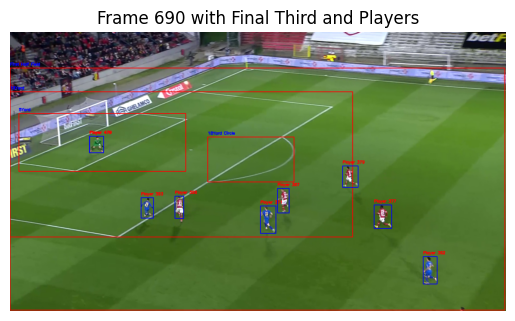

In [8]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

# Load the dataset
file_path = 'all_tracking_data.csv'  # Ensure the correct path is provided
data = pd.read_csv(file_path)

# Function to parse bounding boxes
def parse_bbox(bbox_str):
    return ast.literal_eval(bbox_str)

# Function to draw pitch parts, players, and the final third on a frame
def draw_overlay(frame, pitch_part_data, player_data, final_third):
    # Draw final third
    cv2.rectangle(frame, 
                  (int(final_third[0]), int(final_third[2])), 
                  (int(final_third[1]), int(final_third[3])), 
                  (0, 255, 0), 2)  # Green for the final third

    # Draw pitch parts
    for _, row in pitch_part_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
        cv2.putText(frame, row['ID'], (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Draw players
    for _, row in player_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
        cv2.putText(frame, f'Player {row["ID"]}', (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to process a single frame and display it
def process_frame(video_path, frame_number, output_folder):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to read the frame.")
        return

    frame_data = data[data['Frame'] == frame_number]
    pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
    player_data = frame_data[frame_data['Type'] == 'Player']

    # Calculate the final third dynamically
    frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)
    xmin_final_third = frame_data['BBox_parsed'].apply(lambda x: x[0]).min()
    xmax_final_third = frame_data['BBox_parsed'].apply(lambda x: x[2]).max()
    ymin_final_third = frame_data['BBox_parsed'].apply(lambda x: x[1]).min()
    ymax_final_third = frame_data['BBox_parsed'].apply(lambda x: x[3]).max()
    final_third_boundaries = (xmin_final_third, xmax_final_third, ymin_final_third, ymax_final_third)

    frame = draw_overlay(frame, pitch_part_data, player_data, final_third_boundaries)

    # Convert frame from BGR to RGB for correct color display in matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number} with Final Third and Players')
    plt.axis('off')
    plt.savefig(output_folder)
    plt.show()

# Specify the frame number and video path
frame_number = 690  # The frame number to process
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path
output_folder = 'output_frames'  # Replace with your desired output folder path

# Call the function to process and display the frame
process_frame(video_path, frame_number, output_folder)


C:\Users\Dokutsu\AppData\Local\Temp\ipykernel_2528\3753748496.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)


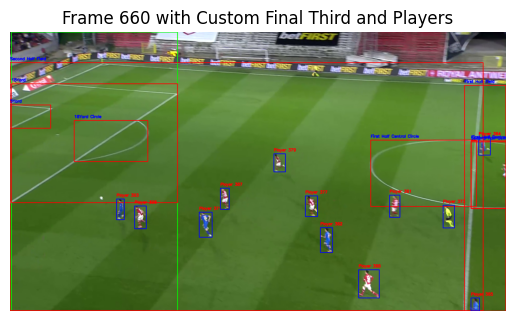

In [10]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to parse bounding boxes
def parse_bbox(bbox_str):
    return ast.literal_eval(bbox_str)

# Function to calculate the custom final third boundaries based on the 18-yard box
def calculate_custom_final_third(frame_data):
    frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)
    
    # Use X-coordinates from the 18Yard pitch parts
    relevant_pitch_parts = frame_data[frame_data['ID'].str.contains('18Yard')]
    if not relevant_pitch_parts.empty:
        xmin = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[0]).min()
        xmax = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[2]).max()
    else:
        return None

    return (xmin, xmax)

# Function to draw pitch parts, players, and the custom final third on a frame
def draw_overlay(frame, pitch_part_data, player_data, custom_final_third_x):
    if custom_final_third_x:
        xmin_custom_final_third, xmax_custom_final_third = custom_final_third_x
        frame_height = frame.shape[0]
        # Draw custom final third boundaries
        cv2.rectangle(frame, 
                      (int(xmin_custom_final_third), 0), 
                      (int(xmax_custom_final_third), frame_height), 
                      (0, 255, 0), 2)  # Green for the custom final third

    # Draw pitch parts
    for _, row in pitch_part_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
        cv2.putText(frame, row['ID'], (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Draw players
    for _, row in player_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
        cv2.putText(frame, f'Player {row["ID"]}', (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to process and display the custom final third for a specific frame
def process_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to read the frame.")
        return

    frame_data = data[data['Frame'] == frame_number]
    pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
    player_data = frame_data[frame_data['Type'] == 'Player']

    custom_final_third_x = calculate_custom_final_third(pitch_part_data)
    frame = draw_overlay(frame, pitch_part_data, player_data, custom_final_third_x)

    # Convert frame from BGR to RGB for correct color display in matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number} with Custom Final Third and Players')
    plt.axis('off')
    plt.show()

# Specify the frame number and video path
frame_number = 660  # The frame number to process
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path

# Call the function to process and display the frame
process_frame(video_path, frame_number)


C:\Users\Dokutsu\AppData\Local\Temp\ipykernel_2528\4167262230.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)


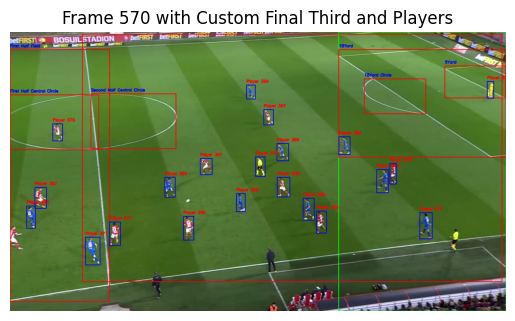

In [15]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to parse bounding boxes
def parse_bbox(bbox_str):
    return ast.literal_eval(bbox_str)

# Function to calculate the custom final third boundaries based on the 18-yard box
def calculate_custom_final_third(frame_data):
    frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)
    
    # Use X-coordinates from the 18Yard pitch parts
    relevant_pitch_parts = frame_data[frame_data['ID'].str.contains('18Yard')]
    if not relevant_pitch_parts.empty:
        xmin = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[0]).min()
        xmax = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[2]).max()
    else:
        return None

    # No need for midpoint calculation, just use xmin and xmax directly
    return (xmin, xmax)

# Function to draw pitch parts, players, and the custom final third on a frame
def draw_overlay(frame, pitch_part_data, player_data, custom_final_third_x):
    if custom_final_third_x:
        xmin_custom_final_third, xmax_custom_final_third = custom_final_third_x
        frame_height = frame.shape[0]
        # Draw custom final third boundaries
        cv2.rectangle(frame, 
                      (int(xmin_custom_final_third), 0), 
                      (int(xmax_custom_final_third), frame_height), 
                      (0, 255, 0), 2)  # Green for the custom final third

    # Draw pitch parts
    for _, row in pitch_part_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
        cv2.putText(frame, row['ID'], (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Draw players
    for _, row in player_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
        cv2.putText(frame, f'Player {row["ID"]}', (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to process and display the custom final third for a specific frame
def process_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to read the frame.")
        return

    frame_data = data[data['Frame'] == frame_number]
    pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
    player_data = frame_data[frame_data['Type'] == 'Player']

    custom_final_third_x = calculate_custom_final_third(pitch_part_data)
    frame = draw_overlay(frame, pitch_part_data, player_data, custom_final_third_x)

    # Convert frame from BGR to RGB for correct color display in matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number} with Custom Final Third and Players')
    plt.axis('off')
    plt.show()

# Specify the frame number and video path
frame_number = 570  # The frame number to process
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path

# Call the function to process and display the frame
process_frame(video_path, frame_number)


C:\Users\Dokutsu\AppData\Local\Temp\ipykernel_2528\1200612501.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)


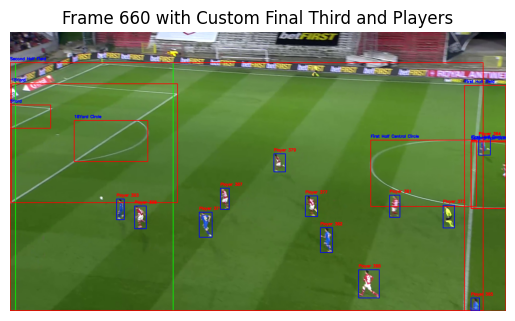

In [16]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to parse bounding boxes
def parse_bbox(bbox_str):
    return ast.literal_eval(bbox_str)

# Function to calculate the custom final third boundaries based on the 18-yard box and visible field
def calculate_custom_final_third(frame_data):
    frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)
    
    # Use X-coordinates from the 18Yard pitch parts
    relevant_pitch_parts = frame_data[frame_data['ID'].str.contains('18Yard')]
    if not relevant_pitch_parts.empty:
        xmin_18yard = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[0]).min()
        xmax_18yard = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[2]).max()
    else:
        return None

    # Use Y-coordinates from the widest visible field part
    field_parts = frame_data[frame_data['ID'].str.contains('Second Half Field')]
    if not field_parts.empty:
        ymin_field = field_parts['BBox_parsed'].apply(lambda x: x[1]).min()
        ymax_field = field_parts['BBox_parsed'].apply(lambda x: x[3]).max()
    else:
        ymin_field = 0
        ymax_field = frame_data['BBox_parsed'].apply(lambda x: x[3]).max()

    # Calculate the midpoint of the 18-yard box
    mid_x = (xmin_18yard + xmax_18yard) / 2
    
    # Calculate the width of the final third
    field_width = field_parts['BBox_parsed'].apply(lambda x: x[2]).max() - field_parts['BBox_parsed'].apply(lambda x: x[0]).min()
    final_third_width = field_width / 3

    # Calculate the final third boundaries
    custom_xmin = mid_x - final_third_width / 2
    custom_xmax = mid_x + final_third_width / 2

    return (custom_xmin, custom_xmax, ymin_field, ymax_field)

# Function to draw pitch parts, players, and the custom final third on a frame
def draw_overlay(frame, pitch_part_data, player_data, custom_final_third):
    if custom_final_third:
        xmin_custom_final_third, xmax_custom_final_third, ymin_custom_final_third, ymax_custom_final_third = custom_final_third
        # Draw custom final third boundaries
        cv2.rectangle(frame, 
                      (int(xmin_custom_final_third), int(ymin_custom_final_third)), 
                      (int(xmax_custom_final_third), int(ymax_custom_final_third)), 
                      (0, 255, 0), 2)  # Green for the custom final third

    # Draw pitch parts
    for _, row in pitch_part_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
        cv2.putText(frame, row['ID'], (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Draw players
    for _, row in player_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
        cv2.putText(frame, f'Player {row["ID"]}', (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to process and display the custom final third for a specific frame
def process_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to read the frame.")
        return

    frame_data = data[data['Frame'] == frame_number]
    pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
    player_data = frame_data[frame_data['Type'] == 'Player']

    custom_final_third = calculate_custom_final_third(pitch_part_data)
    frame = draw_overlay(frame, pitch_part_data, player_data, custom_final_third)

    # Convert frame from BGR to RGB for correct color display in matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number} with Custom Final Third and Players')
    plt.axis('off')
    plt.show()

# Specify the frame number and video path
frame_number = 660  # The frame number to process
video_path = 'input_videos/antwerp_angle.mp4'  # Replace with your video file path

# Call the function to process and display the frame
process_frame(video_path, frame_number)


C:\Users\Dokutsu\AppData\Local\Temp\ipykernel_2528\105823356.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)


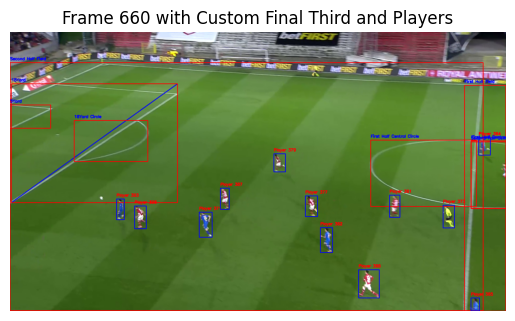

In [20]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

# Load the dataset
file_path = 'all_tracking_data.csv'
data = pd.read_csv(file_path)

# Function to parse bounding boxes
def parse_bbox(bbox_str):
    return ast.literal_eval(bbox_str)

# Function to calculate the custom final third boundaries based on the 18-yard box and orientation
def calculate_custom_final_third(frame_data):
    frame_data['BBox_parsed'] = frame_data['BBox'].apply(parse_bbox)
    
    # Use coordinates from the 18Yard pitch parts
    relevant_pitch_parts = frame_data[frame_data['ID'].str.contains('18Yard')]
    if not relevant_pitch_parts.empty:
        xmin_18yard = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[0]).min()
        xmax_18yard = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[2]).max()
        ymin_18yard = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[1]).min()
        ymax_18yard = relevant_pitch_parts['BBox_parsed'].apply(lambda x: x[3]).max()
    else:
        return None

    # Calculate the coordinates for the orientation line
    top_right = (xmax_18yard, ymin_18yard)
    bottom_left = (xmin_18yard, ymax_18yard)
    
    return (xmin_18yard, xmax_18yard, ymin_18yard, ymax_18yard, top_right, bottom_left)

# Function to draw pitch parts, players, the custom final third, and the orientation line on a frame
def draw_overlay(frame, pitch_part_data, player_data, custom_final_third):
    if custom_final_third:
        xmin_custom_final_third, xmax_custom_final_third, ymin_custom_final_third, ymax_custom_final_third, top_right, bottom_left = custom_final_third
        # Draw custom final third boundaries
        cv2.rectangle(frame, 
                      (int(xmin_custom_final_third), int(ymin_custom_final_third)), 
                      (int(xmax_custom_final_third), int(ymax_custom_final_third)), 
                      (0, 255, 0), 2)  # Green for the custom final third
        
        # Draw the orientation line
        cv2.line(frame, 
                 (int(top_right[0]), int(top_right[1])), 
                 (int(bottom_left[0]), int(bottom_left[1])), 
                 (255, 0, 0), 2)  # Blue for the orientation line

    # Draw pitch parts
    for _, row in pitch_part_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
        cv2.putText(frame, row['ID'], (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Draw players
    for _, row in player_data.iterrows():
        bbox = parse_bbox(row['BBox'])
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
        cv2.putText(frame, f'Player {row["ID"]}', (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return frame

# Function to process and display the custom final third for a specific frame
def process_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to read the frame.")
        return

    frame_data = data[data['Frame'] == frame_number]
    pitch_part_data = frame_data[frame_data['Type'] == 'Pitch Part']
    player_data = frame_data[frame_data['Type'] == 'Player']

    custom_final_third = calculate_custom_final_third(pitch_part_data)
    frame = draw_overlay(frame, pitch_part_data, player_data, custom_final_third)

    # Convert frame from BGR to RGB for correct color display in matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number} with Custom Final Third and Players')
    plt.axis('off')
    plt.show()

# Specify the frame number and video path
frame_number = 660  # The frame number to process
video_path = video_path  # Replace with your video file path

# Call the function to process and display the frame
process_frame(video_path, frame_number)


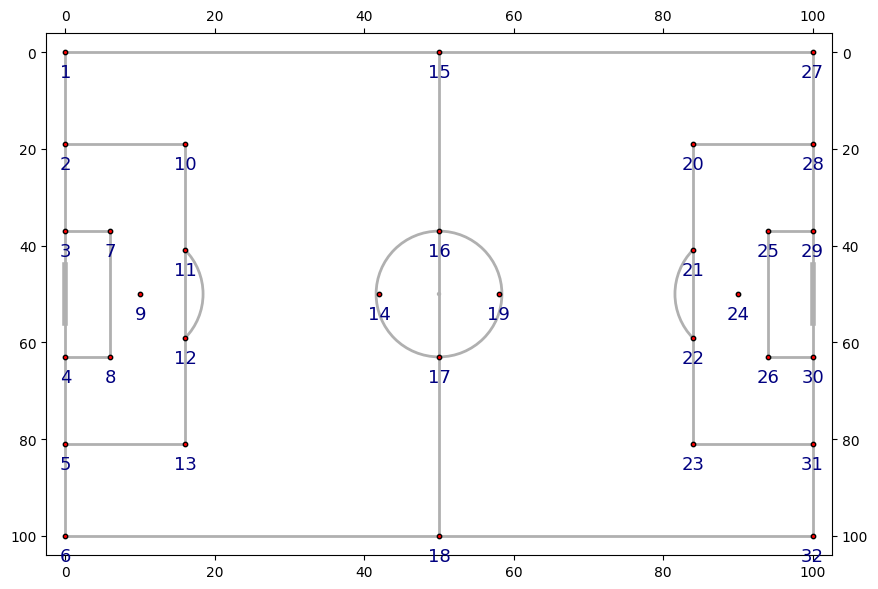

In [104]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np

# Define the pitch with Opta dimensions
pitch = Pitch(pitch_type='wyscout', axis=True, label=True, tick=True)
fig, ax = pitch.draw(figsize=(10, 6))

# Define the 32 points, carefully positioned to match usual football pitch markings
standard_pitch_points = np.array([
    [0, 0],     # 01
    [0, 19],    # 02 
    [0, 37],      # 03 
    [0, 63],    # 04 
    [0, 81],      # 05 
    [0, 100],       # 06 
    [6, 37],   # 07
    [6, 63],  # 08 
    [10, 50],    # 09
    [16, 19],  # 10 
    [16, 41],    # 11 
    [16, 59],      # 12 
    [16, 81],    # 13 
    [42, 50],      # 14 
    [50, 0],     # 15 
    [50, 37],    # 16 
    [50, 63],    # 17 
    [50, 100],      # 18 
    [58, 50],      # 19 
    [84, 19],      # 20 
    [84, 41],      # 21 
    [84, 59],    # 22 
    [84, 81],    # 23 
    [90, 50],  # 24 
    [94, 37],  # 25 
    [94, 63],     # 26 
    [100, 0],     # 27 
    [100, 19],     # 28 
    [100, 37],     # 29 
    [100, 63],      # 30 
    [100, 81],     # 31
    [100, 100]     # 32
], dtype=np.float32)

# Plot each point with labels
for i, (x, y) in enumerate(standard_pitch_points):
    pitch.scatter(x, y, s=10, color='red', edgecolors='black', linewidth=1, ax=ax, zorder=3)
    ax.text(x, y +6, f'{i+1}', fontsize=13, ha='center', va='bottom', color='navy')

plt.show()
